# AlphaZero from scratch under 250 lines of code!

This is by far the cleanest implementation of AlphaZero on the internet.
This could be considered as a simplified version of suragnair's implementation inspired from higgsfield's RL Adventure.

- Uses PyTorch.
- Using standard PettingZoo api for env.
- The implementation is true to the paper afaik. HyperParameters are changed to suit the simple envs.
- Not tested on GPU.
- Only tictactoe and connect4 are tested. Simply change tictactoe_v3 to connect_four_v3 for connect4.

In [ ]:
from IPython.display import clear_output
from collections import deque
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from pettingzoo.classic import tictactoe_v3  # connect_four_v3
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchmetrics import MeanMetric
from tqdm import tqdm

# Neural Network

In [ ]:
class AlphaZeroModel(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(AlphaZeroModel, self).__init__()
        self.v = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh(),
        )

        self.p = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Linear(256, num_outputs),
            nn.Softmax(dim=1),
        )

    def forward(self, s):
        return self.p(s), self.v(s)

# MCTS

In [ ]:
class MCTS:
    def __init__(self, model):
        self.model = model
        self.q_sa = {}  # stores Q values for (s, a)
        self.n_sa = {}  # stores # of times edge (s, a) was visited
        self.p_s = {}  # stores initial policy returned by neural net

    def simulate(self, env):
        s = tuple(env.observe(env.agents[0])['observation'].flatten())  # (18,)
        observation = env.observe(env.agent_selection)
        action_mask = observation['action_mask']  # (9,)
        observation = observation['observation']  # (3, 3, 2)

        """ EVALUATE """
        # If s is leaf, then evaluate s with model
        if s not in self.p_s:
            p, v = self.evaluate(observation, action_mask, model)
            self.p_s[s] = p
            return -v

        """ SELECT """
        a = self.select(s, action_mask)

        """ EXPAND """
        next_env = deepcopy(env)
        next_env.step(a)
        agent = env.agent_selection
        # If terminal state, v = z
        if next_env.terminations[agent] or next_env.truncations[agent]:
            v = next_env.rewards[agent]
        else:
            v = self.simulate(next_env)

        """ BACKTRACK """
        if (s, a) in self.q_sa:
            # Recompute the average
            sum_ = self.n_sa[(s, a)] * self.q_sa[(s, a)] + v
            self.n_sa[(s, a)] += 1
            self.q_sa[(s, a)] = sum_ / self.n_sa[(s, a)]
        else:
            self.q_sa[(s, a)] = v
            self.n_sa[(s, a)] = 1
        return -v

    def select(self, s, action_mask, cpuct=1):
        """Pick the action with the highest upper confidence bound"""
        q = np.array([self.q_sa.get((s, a), 0) for a in range(len(action_mask))])
        n = np.array([self.n_sa.get((s, a), 0) for a in range(len(action_mask))])

        # (1− ε)pa+ εηa, where η∼ Dir(0.03) and ε= 0.25
        p = 0.75 * self.p_s[s] + 0.25 * np.random.dirichlet([2] * len(q))

        u = q + cpuct * p * np.sqrt(n.sum() + 1e-6) / (1 + n)
        u[action_mask == 0] = -np.inf
        return u.argmax()

    @staticmethod
    def evaluate(observation, action_mask, model):
        observation = torch.from_numpy(observation).float().view(1, -1)  # (1, 18)

        # Get predictions
        model.eval()
        with torch.no_grad():
            p, v = model(observation)  # (1, 9), (1, 1)
        p = p.cpu().numpy()[0]  # (9,)
        v = v.cpu().numpy()[0][0]  # scalar

        # Legal action masking.
        p *= action_mask

        # Normalizing probabilities
        p_sum = p.sum()
        if p_sum > 0:
            p /= p_sum  # re-normalize
        else:
            print("All valid moves were masked, doing a workaround.")
            p += action_mask
            p /= p.sum()

        return p, v

    def get_action_prob(self, env, temperature=1):
        s = tuple(env.observe(env.agents[0])['observation'].flatten())  # (18,)
        p = [self.n_sa.get((s, a), 0) for a in range(len(self.p_s[s]))]
        p = np.array(p, dtype=np.float32) ** 1 / temperature
        return p / p.sum()

# Helper functions

In [ ]:
def plot(iteration, losses, win_rates, lose_rates):
    clear_output(True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(f"Loss. Iteration: {iteration}")
    ax1.plot(losses)
    ax2.set_title(f'Win rate and lose rate')
    ax2.plot(win_rates, label='Win Rate')
    ax2.plot(lose_rates, label='Lose Rate')
    ax2.legend()
    plt.show()


def evaluate(env, model_1, model_2, n_episodes):
    wins_1, wins_2 = 0, 0
    for _ in tqdm(range(n_episodes), desc='Evaluating'):
        env.reset()
        mcts_ = MCTS(model_1), MCTS(model_2)
        step = 0
        while not (env.terminations[env.agent_selection] or env.truncations[env.agent_selection]):
            step += 1
            mcts = mcts_[int(step % 2 == 0)]

            [mcts.simulate(env) for _ in range(25)]
            p = mcts.get_action_prob(env)
            action = np.random.choice(len(p), p=p)

            env.step(action)
        r = env.rewards[env.agents[0]]
        wins_1 += int(r > 1)
        wins_2 += int(r < 1)
    return wins_1, wins_2


def self_play(env, mcts: MCTS):
    tuples = []
    env.reset()

    while True:
        [mcts.simulate(env) for _ in range(100)]
        p = mcts.get_action_prob(env)
        agent = env.agent_selection
        tuples.append([env.observe(agent)['observation'], p, agent])

        action = np.random.choice(len(p), p=p)
        env.step(action)
        if env.terminations[agent] or env.truncations[agent]:
            for tup in tuples:
                tup[2] = env.rewards[tup[2]]
            return tuples

# Initialization

In [ ]:
env = tictactoe_v3.env()
n_actions = env.action_space(env.possible_agents[0]).n
n_inputs = env.observation_space(env.possible_agents[0])['observation'].sample().flatten().shape[0]

device = 'cpu'
model = AlphaZeroModel(n_inputs, n_actions).to(device)
old_model = deepcopy(model)
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

train_examples_history = deque([], maxlen=25)
losses = []
win_rates = []
lose_rates = []

# Training

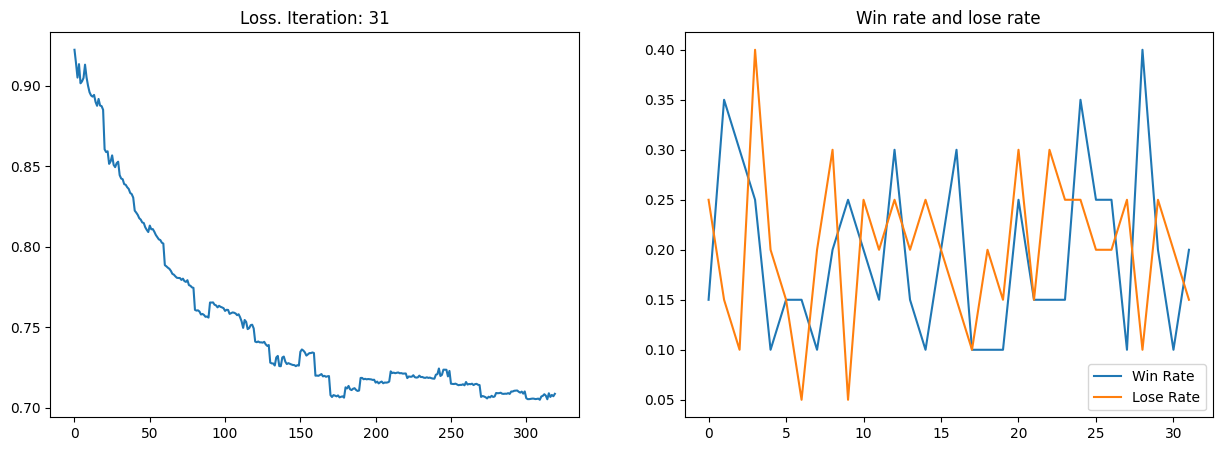

Self-Play:  16%|█▌        | 4/25 [00:02<00:15,  1.37it/s]


KeyboardInterrupt: 

In [ ]:
for iteration in range(1000):
    """ Self Play """
    iteration_train_examples = deque([], maxlen=1000)
    for _ in tqdm(range(25), desc='Self-Play'):
        mcts = MCTS(model)
        iteration_train_examples += self_play(env, mcts)

    """ Prepare Training Data """
    train_examples_history.append(iteration_train_examples)
    dataset = [x for xs in train_examples_history for x in xs]
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    """ Train """
    model.train()
    for epoch in tqdm(range(10), desc='Training'):
        loss_mean = MeanMetric()
        for state, p, v in dataloader:
            p_pred, v_pred = model(state.float().to(device))
            loss = (v.to(device) - v_pred).pow(2).mean() - (p.to(device) * p_pred.log()).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_mean(loss.item())
        losses.append(loss_mean.compute())

    """ Evaluate """
    n_eval_episodes = 20
    wins, loses = [0, 0], [0, 0]
    wins[0], loses[0] = evaluate(env, model, old_model, n_eval_episodes // 2)
    loses[1], wins[1] = evaluate(env, old_model, model, n_eval_episodes // 2)
    win_rates.append(sum(wins) / n_eval_episodes)
    lose_rates.append(sum(loses) / n_eval_episodes)
    if win_rates[-1] > lose_rates[-1]:
        old_model = deepcopy(model)

    plot(iteration, losses, win_rates, lose_rates)

# Debugging stuff

In [7]:
def human_readable_s(s):
    """For debugging purposes"""
    ns = np.zeros((3, 3, 3))
    ns[:, :, 1:] = np.array(s).reshape((3, 3, 2))
    return ns.argmax(axis=2)

def machine_readable_s(s, player=1):
    """Opposite of human_readable_s"""
    # s = (
    #     [1, 0, 0],
    #     [0, 0, 0],
    #     [2, 1, 0],
    # )
    ns = np.zeros((3, 3, 3), dtype=np.int8)
    for i in range(3):
        for j in range(3):
            if player == 1:
                ns[i, j, s[i][j]] = 1
            else:
                ns[i, j, 2 - s[i][j]] = 1
    if player == 1:
        ns = ns[:, :, 1:]  # (3, 3, 2)
    else:
        ns = ns[:, :, :2]
    # ns = tuple(ns.flatten())
    return ns

In [8]:
s = (
    [1, 0, 1],
    [0, 2, 2],
    [0, 0, 1],
)
sm = machine_readable_s(s, player=2)
sm = torch.tensor(sm).float().unsqueeze(0).to(device)
model.eval()
p, v = model(sm)
p, v

(tensor([[3.6898e-06, 2.7540e-01, 4.7416e-06, 6.9145e-01, 7.9069e-05, 1.5673e-04,
          5.7926e-03, 2.7116e-02, 3.4246e-06]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.1466]], grad_fn=<TanhBackward0>))

# Debugging stuff for connect4

In [ ]:
def human_readable_s(s):
    """For debugging purposes"""
    ns = np.zeros((6, 7, 3))
    ns[:, :, 1:] = np.array(s).reshape((6, 7, 2))
    return ns.argmax(axis=2)

def machine_readable_s(s, player=1):
    """Opposite of human_readable_s"""
    # s = (
    #     [0, 0, 0, 0, 0, 0, 0],
    #     [0, 0, 0, 0, 0, 0, 0],
    #     [0, 0, 0, 0, 0, 0, 0],
    #     [0, 0, 0, 0, 0, 0, 0],
    #     [0, 0, 0, 0, 0, 0, 0],
    #     [0, 0, 0, 0, 0, 0, 0],
    # )
    ns = np.zeros((6, 7, 3), dtype=np.int8)
    for i in range(6):
        for j in range(7):
            if player == 1:
                ns[i, j, s[i][j]] = 1
            else:
                ns[i, j, 2 - s[i][j]] = 1
    if player == 1:
        ns = ns[:, :, 1:]  # (3, 3, 2)
    else:
        ns = ns[:, :, :2]
    # ns = tuple(ns.flatten())
    return ns

# Sample Gameplay

In [ ]:
env.reset()
mcts = MCTS(model)

In [ ]:
[mcts.simulate(env) for _ in range(25)]
p = mcts.get_action_prob(env)
# action = np.random.choice(len(p), p=p)
action = p.argmax()
print(f'{p=}\n{action=}\n{env.agent_selection=}')

env.step(action)
print(f'{env.rewards=}')
human_readable_s(env.observe(env.agents[0])['observation'])

# Testing Model

In [ ]:
s = (
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 1, 0],
    [0, 0, 0, 2, 1, 2, 0],
    [1, 1, 1, 2, 1, 2, 0],
)
sm = machine_readable_s(s, player=2)
sm = torch.tensor(sm).float().unsqueeze(0).to(device)
model.eval()
p, v = model(sm)
p.detach().numpy(), v.item()

# Testing MCTS

In [ ]:
env.reset()
mcts = MCTS(model)
_ = [mcts.simulate(env) for _ in tqdm(range(50000))]

In [ ]:
s = (
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 2, 0, 0, 0],
    [0, 1, 2, 1, 0, 1, 2],
)
sm = tuple(machine_readable_s(s).flatten())
mcts.p_s.get(sm)

In [ ]:
[mcts.q_sa.get((sm, a), '') for a in range(7)]

In [ ]:
[mcts.n_sa.get((sm, a), '') for a in range(7)]